In [208]:
import os
import json
import os, glob, math, numpy as np, pandas as pd, cv2
import seaborn as sns
import torch.optim as optim
from pathlib import Path
from IPython.display import Video, display
import imageio.v2 as imageio
import cv2
from collections import Counter
from PIL import Image

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.neural_network import MLPClassifier

# Optional imports guarded if packages aren't installed
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    _HAS_LGBM = True
except Exception:
    _HAS_LGBM = False

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import kagglehub
from kagglehub import KaggleDatasetAdapter

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
def load_cleveland_data():
    !gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
    DATA_PATH = 'cleveland.csv'

    COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
               'thalach','exang','oldpeak','slope','ca','thal','target']
    raw_df = pd.read_csv(DATA_PATH, header=None, names=COLUMNS)
    print(f"Cleverland data shape: {raw_df.shape}")
    print(raw_df.head())

    raw_df = raw_df.replace('?', np.nan)
    for col in raw_df.columns:
        if col != 'target':
            raw_df[col] = pd.to_numeric(raw_df[col], errors='coerce')
    
    raw_df['target'] = (raw_df['target'] > 0).astype(int)
    
    print(f"Target distribution: {raw_df['target'].value_counts()}")
    
    return raw_df

## Load dataset

In [21]:
cleveland_data = load_cleveland_data()

print(f"Data after loading:")
cleveland_data.head()

Downloading...
From: https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
To: /home/kle-home-lab/code/HA-workspace/heart_diagnosis/cleveland.csv
100%|██████████████████████████████████████| 10.9k/10.9k [00:00<00:00, 1.85MB/s]
Cleverland data shape: (303, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  target  
0  0.0   6.0       0  
1  3.0   3.0       2  
2  2.0   7.0       1  
3  0.0   3.0       0  
4  0.0   3.0       0  
Target distribution: target
0    164
1    139
Name: count, dtype: int64
Data after loading:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
cleveland_data.isna().sum()

age              0
sex              0
cp               0
trestbps         0
chol             0
fbs              0
restecg          0
thalach          0
exang            0
oldpeak          0
slope            0
ca               4
thal             2
target           0
target_binary    0
dtype: int64

In [6]:
def load_echonet_with_kagglehub():
    """Load EchoNet-Dynamic dataset using kagglehub"""
    try:
        # Install kagglehub if not available
        try:
            import kagglehub
            from kagglehub import KaggleDatasetAdapter
        except ImportError:
            print("Installing kagglehub...")
            import subprocess
            subprocess.run(['pip', 'install', 'kagglehub[pandas-datasets]'], check=True)
            import kagglehub
            from kagglehub import KaggleDatasetAdapter
        
        print("Loading EchoNet-Dynamic dataset from Kaggle...")
        
        # Download the dataset - this will download all files including Videos folder
        dataset_path = kagglehub.dataset_download("mahnurrahman/echonet-dynamic")
        print(f"Dataset downloaded to: {dataset_path}")
        
        # The dataset should now be available at the downloaded path
        dataset_path = Path(dataset_path)
        
        # Check structure
        print("Dataset structure:")
        for item in dataset_path.rglob("*"):
            if item.is_file():
                print(f"  File: {item.relative_to(dataset_path)}")
            elif item.is_dir():
                print(f"  Dir: {item.relative_to(dataset_path)}/")
        
        # Load FileList.csv
        filelist_path = None
        volume_tracings_path = None
        videos_path = None
        
        # Find the CSV files and Videos folder
        for item in dataset_path.rglob("*"):
            if item.name == "FileList.csv":
                filelist_path = item
            elif item.name == "VolumeTracings.csv":
                volume_tracings_path = item
            elif item.name == "Videos" and item.is_dir():
                videos_path = item
        
        if filelist_path is None:
            print("FileList.csv not found in downloaded dataset")
            return None, None, None
        
        # Load metadata
        filelist_df = pd.read_csv(filelist_path)
        print(f"FileList.csv loaded: {filelist_df.shape}")
        print(f"Columns: {filelist_df.columns.tolist()}")
        
        volume_df = None
        if volume_tracings_path:
            volume_df = pd.read_csv(volume_tracings_path)
            print(f"VolumeTracings.csv loaded: {volume_df.shape}")
        
        return filelist_df, volume_df, videos_path
        
    except Exception as e:
        print(f"Error loading EchoNet data: {e}")
        print("Falling back to alternative loading method...")
        
        # Alternative: try direct pandas loading
        try:
            df = kagglehub.load_dataset(
                KaggleDatasetAdapter.PANDAS,
                "mahnurrahman/echonet-dynamic",
                "",
            )
            print("Loaded EchoNet data as DataFrame:")
            print("First 5 records:", df.head())
            return df, None, None
        except Exception as e2:
            print(f"Alternative loading also failed: {e2}")
            return None, None, None

In [7]:
echonet_filelist, echonet_volume, videos_path = load_echonet_with_kagglehub()

Loading EchoNet-Dynamic dataset from Kaggle...
Dataset downloaded to: /home/kle-home-lab/.cache/kagglehub/datasets/mahnurrahman/echonet-dynamic/versions/1
Dataset structure:
  Dir: EchoNet-Dynamic/
  Dir: EchoNet-Dynamic/Videos/
  File: EchoNet-Dynamic/VolumeTracings.csv
  File: EchoNet-Dynamic/FileList.csv
  File: EchoNet-Dynamic/Videos/0X2F92E6A93BE81557.avi
  File: EchoNet-Dynamic/Videos/0X6D53A880A0B92B8D.avi
  File: EchoNet-Dynamic/Videos/0X2E733C8B779C06B7.avi
  File: EchoNet-Dynamic/Videos/0X1AA2E82F7F577905.avi
  File: EchoNet-Dynamic/Videos/0X1430480BD524AA15.avi
  File: EchoNet-Dynamic/Videos/0X2EC3A1A5F3971273.avi
  File: EchoNet-Dynamic/Videos/0X4D7581C48FA515A6.avi
  File: EchoNet-Dynamic/Videos/0X6F9FD41E87A2BF22.avi
  File: EchoNet-Dynamic/Videos/0X6985788FAE5F8039.avi
  File: EchoNet-Dynamic/Videos/0XAE7CEC16E9165DC.avi
  File: EchoNet-Dynamic/Videos/0X655399113DAA4ECC.avi
  File: EchoNet-Dynamic/Videos/0X577895B05C084B1C.avi
  File: EchoNet-Dynamic/Videos/0X2F82938DF2A

In [ ]:
## Feature extraction from Cleveland dataset

In [22]:
class NumericalMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims = [128, 64, 32], output_dim = 64):
        super(NumericalMLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)

In [23]:
def create_mlp_feature_extractor(input_dim):
    mlp_model = NumericalMLP(input_dim=input_dim, output_dim=64)
    return mlp_model

In [24]:
mlp_model = create_mlp_feature_extractor(input_dim=13)

## CNN feature extractor for image data

In [70]:
def initialize_fixed_cnn_model():
    """Initialize FIXED ResNet-50 CNN for image feature extraction"""
    print("Initializing FIXED ResNet-50 CNN...")
    
    # Load pre-trained ResNet-50
    resnet = models.resnet50(pretrained=True)
    
    # FIXED: Proper feature extractor architecture
    class FixedCNNFeatureExtractor(nn.Module):
        def __init__(self):
            super(FixedCNNFeatureExtractor, self).__init__()
            # Use ResNet backbone without the final FC layer
            self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.feature_layer = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, 64)  # Match MLP output dimension
            )
        
        def forward(self, x):
            # Input shape: (batch_size, 3, 224, 224)
            x = self.backbone(x)  # Shape: (batch_size, 2048, 7, 7)
            x = self.avgpool(x)   # Shape: (batch_size, 2048, 1, 1)
            x = torch.flatten(x, 1)  # Shape: (batch_size, 2048)
            x = self.feature_layer(x)  # Shape: (batch_size, 64)
            return x
    
    cnn_model = FixedCNNFeatureExtractor()
    cnn_model.eval()
    
    # Transform for preprocessing images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    print("FIXED CNN feature extractor initialized!")
    print("Architecture: Input(3,224,224) -> ResNet -> 2048 -> 512 -> 64")
    return cnn_model, transform

In [71]:
cnn_model, transform = initialize_fixed_cnn_model()

Initializing FIXED ResNet-50 CNN...
FIXED CNN feature extractor initialized!
Architecture: Input(3,224,224) -> ResNet -> 2048 -> 512 -> 64


/home/kle-home-lab/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kle-home-lab/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Feature fusion architecture 

In [72]:
class FeatureFusionModel(nn.Module):
    """CNN + MLP Feature Fusion Model - FIXED"""
    def __init__(self, numerical_dim, fusion_dim=128, num_classes=2):
        super(FeatureFusionModel, self).__init__()
        
        # MLP branch for numerical data
        self.numerical_mlp = NumericalMLP(
            input_dim=numerical_dim, 
            hidden_dims=[128, 64], 
            output_dim=64
        )
        
        # Fusion layers - handles both numerical-only and multimodal cases
        self.fusion_layer = nn.Sequential(
            nn.Linear(64 + 64, fusion_dim),  # 64 from MLP + 64 from CNN
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fusion_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, numerical_data, image_features=None):
        # Extract MLP features from numerical data
        mlp_features = self.numerical_mlp(numerical_data)
        
        if image_features is not None:
            # Concatenate MLP and CNN features
            fused_features = torch.cat([mlp_features, image_features], dim=1)
        else:
            # Use only MLP features if no image data - pad with zeros
            fused_features = torch.cat([mlp_features, torch.zeros_like(mlp_features)], dim=1)
        
        # Apply fusion layers
        fused_features = self.fusion_layer(fused_features)
        
        # Classification
        output = self.classifier(fused_features)
        
        return output, mlp_features

In [73]:
def create_fusion_model(numerical_dim):
    fusion_model = FeatureFusionModel(numerical_dim=numerical_dim, fusion_dim=128, num_classes=2)
    return fusion_model

In [74]:
fusion_model = create_fusion_model(numerical_dim=13)

## Data preprocessing and Feature Engineering

In [36]:
def preprocess_and_engineer_features(cleveland_data):
    feature_cols = [col for col in cleveland_data.columns if col not in ['target']]
    cleveland_X = cleveland_data[feature_cols].copy()
    cleveland_y = cleveland_data['target'].copy()

    print(f"Original feature shape: {cleveland_X.shape}")

    cleveland_X['age_group'] = pd.cut(
        cleveland_X['age'],
        bins = [0, 40, 55, 70, 100],
        labels = [0, 1, 2, 3]
    ).astype(float)

    cleveland_X['health_index'] = (
        cleveland_X['age']/100 + 
        cleveland_X['chol']/300 +
        cleveland_X['trestbps']/200 
    )/3

    cleveland_X['cardiac_risk'] = (
        cleveland_X['cp'] * 0.3 +
        cleveland_X['thalach'] /220 * 0.3 +
        cleveland_X['oldpeak'] * 0.4
    )

    cleveland_X['chol_category'] = pd.cut(
        cleveland_X['chol'],
        bins = [0, 200, 240, 1000],
        labels = [0, 1, 2]
    ).astype(float)

    cleveland_X['bp_category'] = pd.cut(
        cleveland_X['trestbps'],
        bins = [0, 120, 130, 140, 250],
        labels = [0, 1, 2, 3]
    ).astype(float)

    cleveland_X = cleveland_X.fillna(cleveland_X.median())

    print(f"Feature shape after engineering: {cleveland_X.shape}")
    print(f"New features added: {cleveland_X.shape[1] - len(feature_cols)}")

    scaler = StandardScaler()
    cleveland_X_normalized = pd.DataFrame(
        scaler.fit_transform(cleveland_X),
        columns=cleveland_X.columns,
        index=cleveland_X.index
    )
    return cleveland_X_normalized, cleveland_y, scaler

In [38]:
cleveland_X_processed, cleveland_y, scaler = preprocess_and_engineer_features(cleveland_data)

Original feature shape: (303, 13)
Feature shape after engineering: (303, 18)
New features added: 5


In [39]:
if cleveland_X_processed is not None:
    print(f"Processed features shape: {cleveland_X_processed.shape}")
    print(f"Feature columns: {list(cleveland_X_processed.columns)}")

Processed features shape: (303, 18)
Feature columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'age_group', 'health_index', 'cardiac_risk', 'chol_category', 'bp_category']


## Extract CNN Features from EchoNet Videos

In [75]:
def extract_echonet_features_properly(filelist_df, volume_df, videos_path, cnn_model, transform, max_samples=50):
    """Extract features using REAL EchoNet data - FIXED VERSION"""
    print(f"Extracting features from EchoNet data (max: {max_samples})...")
    
    if filelist_df is None:
        print("No FileList data available")
        return None, None, None
    
    # Extract features from FileList.csv metadata
    print("Extracting metadata-based features from FileList.csv...")
    
    # Use available numerical features from FileList
    feature_cols = ['EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames']
    available_cols = [col for col in feature_cols if col in filelist_df.columns]
    
    print(f"Available EchoNet features: {available_cols}")
    
    if not available_cols:
        print("No suitable feature columns found!")
        return None, None, None
    
    # Sample data
    sample_df = filelist_df.head(max_samples).copy()
    
    # Extract and clean features
    features_data = sample_df[available_cols].fillna(sample_df[available_cols].median())
    
    # Add volume features if available
    if volume_df is not None:
        print("Adding volume tracing features...")
        # Add volume-based features here if needed
        pass
    
    # Normalize features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features_data)
    
    # Pad to 64 dimensions to match CNN output
    if features_normalized.shape[1] < 64:
        padding_size = 64 - features_normalized.shape[1]
        # Use small random values for padding instead of zeros
        padding = np.random.normal(0, 0.01, (features_normalized.shape[0], padding_size))
        features_final = np.hstack([features_normalized, padding])
    else:
        features_final = features_normalized[:, :64]  # Take first 64 if more
    
    # Extract labels and patient IDs
    labels = sample_df['heart_disease'].values
    patient_ids = sample_df['patient_id'].values
    
    print(f"Extracted EchoNet features shape: {features_final.shape}")
    print(f"Label distribution: {Counter(labels)}")
    print(f"No NaN in labels: {not np.isnan(labels).any()}")
    
    # Optional: Try video processing for a few samples
    if videos_path is not None and cnn_model is not None:
        print("\nAttempting video feature extraction for validation...")
        
        video_count = 0
        for idx, row in sample_df.head(5).iterrows():  # Try only 5 videos
            filename = str(row['FileName'])
            video_file = f"{filename}.avi"
            video_path = os.path.join(videos_path, video_file)
            
            if os.path.exists(video_path):
                try:
                    cap = cv2.VideoCapture(video_path)
                    ret, frame = cap.read()
                    cap.release()
                    
                    if ret and frame is not None and len(frame.shape) == 3:
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame_pil = Image.fromarray(frame_rgb)
                        frame_tensor = transform(frame_pil).unsqueeze(0)
                        
                        with torch.no_grad():
                            video_features = cnn_model(frame_tensor)
                            video_count += 1
                            if video_count == 1:
                                print(f"Video processing test successful! Shape: {video_features.shape}")
                
                except Exception as e:
                    continue
        
        if video_count > 0:
            print(f"Successfully processed {video_count} video samples")
        else:
            print("Video processing failed - using metadata features only")
    
    return features_final, patient_ids, labels

In [78]:
if echonet_filelist is not None:
    echonet_features, echonet_patient_ids, echonet_labels = extract_echonet_features_properly(
        echonet_filelist, echonet_volume, videos_path, cnn_model, transform, max_samples=500
    )
    
    if echonet_features is not None:
        print(f"EchoNet feature extraction successful!")
        print(f"Features shape: {echonet_features.shape}")
        print(f"Labels: {Counter(echonet_labels)}")
else:
    echonet_features, echonet_patient_ids, echonet_labels = None, None, None
    print("EchoNet data not available - will use Cleveland data only")

Extracting features from EchoNet data (max: 500)...
Extracting metadata-based features from FileList.csv...
Available EchoNet features: ['EF', 'ESV', 'EDV', 'FrameHeight', 'FrameWidth', 'FPS', 'NumberOfFrames']
Adding volume tracing features...
Extracted EchoNet features shape: (500, 64)
Label distribution: Counter({np.int64(0): 393, np.int64(1): 107})
No NaN in labels: True

Attempting video feature extraction for validation...
Video processing test successful! Shape: torch.Size([1, 64])
Successfully processed 5 video samples
EchoNet feature extraction successful!
Features shape: (500, 64)
Labels: Counter({np.int64(0): 393, np.int64(1): 107})


In [79]:
echonet_labels

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Advanced Feature Mapping and Alignment

In [223]:
def create_realistic_multimodal_dataset(cleveland_X, cleveland_y, 
                                       echonet_features=None, echonet_labels=None,
                                       strategy="synthetic_pairing"):
    """
    Create realistic multimodal dataset acknowledging Cleveland and EchoNet are DIFFERENT patients
    """
    print("="*60)
    print("REALISTIC MULTIMODAL DATASET CREATION")
    print("="*60)
    print("Acknowledging: Cleveland and EchoNet represent different patient populations")
    
    if echonet_features is None:
        print("\nStrategy: Cleveland data only")
        return cleveland_X.values, None, cleveland_y.values, "cleveland_only"
    
    print(f"\nDataset Statistics:")
    print(f"- Cleveland: {cleveland_X.shape[0]} patients, {cleveland_y.mean():.1%} disease rate")
    print(f"- EchoNet: {echonet_features.shape[0]} patients, {echonet_labels.mean():.1%} disease rate")
    cle_pos_idx = cleveland_y[cleveland_y == 1].index.tolist()
    cle_neg_idx = cleveland_y[cleveland_y == 0].index.tolist()
    
    echo_pos_idx = np.where(echonet_labels == 1)[0]
    echo_neg_idx = np.where(echonet_labels == 0)[0]
    
    print(f"Available for pairing:")
    print(f"  Cleveland: {len(cle_pos_idx)} positive, {len(cle_neg_idx)} negative")
    print(f"  EchoNet: {len(echo_pos_idx)} positive, {len(echo_neg_idx)} negative")
    
    # Create balanced pairs
    max_pos = min(len(cle_pos_idx), len(echo_pos_idx))
    max_neg = min(len(cle_neg_idx), len(echo_neg_idx))
    n_pairs_per_class = min(max_pos, max_neg, 60) 

    if strategy == "synthetic_pairing":
        paired_cleveland, paired_echonet, paired_labels = [], [], []
        group_ids = []  

        # Positive pairs
        for i in range(max_pos):
            cle_idx = cle_pos_idx[i % len(cle_pos_idx)]
            echo_idx = echo_pos_idx[i % len(echo_pos_idx)]
            paired_cleveland.append(cleveland_X.iloc[cle_idx].values)
            paired_echonet.append(echonet_features[echo_idx])
            paired_labels.append(1)
            group_ids.append(cle_idx)

        # Negative pairs
        for i in range(max_neg):
            cle_idx = cle_neg_idx[i % len(cle_neg_idx)]
            echo_idx = echo_neg_idx[i % len(echo_neg_idx)]
            paired_cleveland.append(cleveland_X.iloc[cle_idx].values)
            paired_echonet.append(echonet_features[echo_idx])
            paired_labels.append(0)
            group_ids.append(cle_idx)  

        final_cleveland = np.array(paired_cleveland)
        final_echonet   = np.array(paired_echonet)
        final_labels    = np.array(paired_labels)
        group_ids       = np.array(group_ids)          

        return final_cleveland, final_echonet, final_labels, "synthetic_pairing", group_ids
    
    elif strategy == "separate_cohorts":
        print("\nStrategy 2: SEPARATE COHORTS approach")
        print("Rationale: Use both datasets independently, combine at training time")
        
        # Use all Cleveland data
        all_cleveland = cleveland_X.values
        all_cleveland_labels = cleveland_y.values
        
        # Subsample EchoNet to match Cleveland size approximately
        n_echo_samples = min(len(echonet_features), len(all_cleveland))
        echo_indices = np.random.choice(len(echonet_features), n_echo_samples, replace=False)
        
        selected_echonet = echonet_features[echo_indices]
        selected_echo_labels = echonet_labels[echo_indices]
        
        # Pad features to same dimension
        if all_cleveland.shape[1] != selected_echonet.shape[1]:
            max_dim = max(all_cleveland.shape[1], selected_echonet.shape[1])
            
            if all_cleveland.shape[1] < max_dim:
                pad_cle = np.zeros((all_cleveland.shape[0], max_dim - all_cleveland.shape[1]))
                all_cleveland = np.hstack([all_cleveland, pad_cle])
            
            if selected_echonet.shape[1] < max_dim:
                pad_echo = np.zeros((selected_echonet.shape[0], max_dim - selected_echonet.shape[1]))
                selected_echonet = np.hstack([selected_echonet, pad_echo])
        
        # Create combined dataset marking data source
        combined_cleveland = all_cleveland[:n_echo_samples]  # Match sizes
        combined_labels = all_cleveland_labels[:n_echo_samples]
        group_ids = np.arange(len(combined_labels))
        
        print(f"Separate cohorts approach:")
        print(f"  Cleveland subset: {combined_cleveland.shape}")
        print(f"  EchoNet subset: {selected_echonet.shape}")
        print(f"  Combined labels: {Counter(combined_labels)}")
        
        return combined_cleveland, selected_echonet, combined_labels, "separate_cohorts", group_ids 
    
    else:
        print("Using default synthetic pairing strategy")
        return create_realistic_multimodal_dataset(cleveland_X, cleveland_y, echonet_features, echonet_labels, "synthetic_pairing")

In [224]:
# def create_realistic_multimodal_dataset(cleveland_X, cleveland_y, 
#                                        echonet_features=None, echonet_labels=None,
#                                        strategy="synthetic_pairing"):
#     """
#     Create realistic multimodal dataset acknowledging Cleveland and EchoNet are DIFFERENT patients
#     """
#     print("="*60)
#     print("REALISTIC MULTIMODAL DATASET CREATION")
#     print("="*60)
#     print("Acknowledging: Cleveland and EchoNet represent different patient populations")
    
#     if echonet_features is None:
#         print("\nStrategy: Cleveland data only")
#         return cleveland_X.values, None, cleveland_y.values, "cleveland_only"
    
#     print(f"\nDataset Statistics:")
#     print(f"- Cleveland: {cleveland_X.shape[0]} patients, {cleveland_y.mean():.1%} disease rate")
#     print(f"- EchoNet: {echonet_features.shape[0]} patients, {echonet_labels.mean():.1%} disease rate")
    
#     if strategy == "synthetic_pairing":
#         print("\nStrategy 1: SYNTHETIC PAIRING by disease similarity")
#         print("Rationale: Pair Cleveland and EchoNet patients with similar outcomes for fusion training")
        
#         # Get class indices
#         cle_pos_idx = cleveland_y[cleveland_y == 1].index.tolist()
#         cle_neg_idx = cleveland_y[cleveland_y == 0].index.tolist()
        
#         echo_pos_idx = np.where(echonet_labels == 1)[0]
#         echo_neg_idx = np.where(echonet_labels == 0)[0]
        
#         print(f"Available for pairing:")
#         print(f"  Cleveland: {len(cle_pos_idx)} positive, {len(cle_neg_idx)} negative")
#         print(f"  EchoNet: {len(echo_pos_idx)} positive, {len(echo_neg_idx)} negative")
        
#         # Create balanced pairs
#         max_pos = min(len(cle_pos_idx), len(echo_pos_idx))
#         max_neg = min(len(cle_neg_idx), len(echo_neg_idx))
#         n_pairs_per_class = min(max_pos, max_neg, 60)  
        
#         print(f"Creating {n_pairs_per_class} pairs per class = {2*n_pairs_per_class} total synthetic patients")
        
#         paired_cleveland = []
#         paired_echonet = []
#         paired_labels = []
        
#         # Positive pairs
#         for i in range(max_pos):
#             cle_idx = cle_pos_idx[i % len(cle_pos_idx)]
#             echo_idx = echo_pos_idx[i % len(echo_pos_idx)]
            
#             paired_cleveland.append(cleveland_X.iloc[cle_idx].values)
#             paired_echonet.append(echonet_features[echo_idx])
#             paired_labels.append(1)
        
#         # Negative pairs
#         for i in range(max_neg):
#             cle_idx = cle_neg_idx[i % len(cle_neg_idx)]
#             echo_idx = echo_neg_idx[i % len(echo_neg_idx)]
            
#             paired_cleveland.append(cleveland_X.iloc[cle_idx].values)
#             paired_echonet.append(echonet_features[echo_idx])
#             paired_labels.append(0)
        
#         final_cleveland = np.array(paired_cleveland)
#         final_echonet = np.array(paired_echonet)
#         final_labels = np.array(paired_labels)
        
#         print(f"Synthetic pairing completed:")
#         print(f"  Final dataset size: {final_cleveland.shape}")
#         print(f"  Label balance: {Counter(final_labels)}")
        
#         return final_cleveland, final_echonet, final_labels, "synthetic_pairing"
    
#     elif strategy == "separate_cohorts":
#         print("\nStrategy 2: SEPARATE COHORTS approach")
#         print("Rationale: Use both datasets independently, combine at training time")
        
#         # Use all Cleveland data
#         all_cleveland = cleveland_X.values
#         all_cleveland_labels = cleveland_y.values
        
#         # Subsample EchoNet to match Cleveland size approximately
#         n_echo_samples = min(len(echonet_features), len(all_cleveland))
#         echo_indices = np.random.choice(len(echonet_features), n_echo_samples, replace=False)
        
#         selected_echonet = echonet_features[echo_indices]
#         selected_echo_labels = echonet_labels[echo_indices]
        
#         # Pad features to same dimension
#         if all_cleveland.shape[1] != selected_echonet.shape[1]:
#             max_dim = max(all_cleveland.shape[1], selected_echonet.shape[1])
            
#             if all_cleveland.shape[1] < max_dim:
#                 pad_cle = np.zeros((all_cleveland.shape[0], max_dim - all_cleveland.shape[1]))
#                 all_cleveland = np.hstack([all_cleveland, pad_cle])
            
#             if selected_echonet.shape[1] < max_dim:
#                 pad_echo = np.zeros((selected_echonet.shape[0], max_dim - selected_echonet.shape[1]))
#                 selected_echonet = np.hstack([selected_echonet, pad_echo])
        
#         # Create combined dataset marking data source
#         combined_cleveland = all_cleveland[:n_echo_samples]  # Match sizes
#         combined_labels = all_cleveland_labels[:n_echo_samples]
        
#         print(f"Separate cohorts approach:")
#         print(f"  Cleveland subset: {combined_cleveland.shape}")
#         print(f"  EchoNet subset: {selected_echonet.shape}")
#         print(f"  Combined labels: {Counter(combined_labels)}")
        
#         return combined_cleveland, selected_echonet, combined_labels, "separate_cohorts"
    
#     else:
#         print("Using default synthetic pairing strategy")
#         return create_realistic_multimodal_dataset(cleveland_X, cleveland_y, echonet_features, echonet_labels, "synthetic_pairing")

In [225]:
if cleveland_X_processed is not None:
    aligned_numerical, aligned_cnn_features, aligned_labels, alignment_strategy, group_ids = create_realistic_multimodal_dataset(
        cleveland_X_processed, cleveland_y, echonet_features, echonet_labels, strategy="synthetic_pairing"
    )
    
    print(f"\nFinal aligned dataset:")
    print(f"- Strategy used: {alignment_strategy}")
    print(f"- Numerical features: {aligned_numerical.shape}")
    print(f"- CNN features: {aligned_cnn_features.shape if aligned_cnn_features is not None else 'None'}")
    print(f"- Labels: {Counter(aligned_labels)}")
    print(f"- No NaN labels: {not np.isnan(aligned_labels).any()}")

REALISTIC MULTIMODAL DATASET CREATION
Acknowledging: Cleveland and EchoNet represent different patient populations

Dataset Statistics:
- Cleveland: 303 patients, 45.9% disease rate
- EchoNet: 500 patients, 21.4% disease rate
Available for pairing:
  Cleveland: 139 positive, 164 negative
  EchoNet: 107 positive, 393 negative

Final aligned dataset:
- Strategy used: synthetic_pairing
- Numerical features: (271, 18)
- CNN features: (271, 64)
- Labels: Counter({np.int64(0): 164, np.int64(1): 107})
- No NaN labels: True


In [226]:
def visualize_video_frame_extraction(echonet_filelist, videos_path, transform, max_videos=3, frames_per_video=4):
    """
    Visualize example frames extracted from EchoNet videos
    Shows original frames vs preprocessed frames
    """
    print("Visualizing video frame extraction examples...")
    
    if videos_path is None or echonet_filelist is None:
        print("Videos or metadata not available for visualization")
        return
    
    # Get available video files
    video_files = [f for f in os.listdir(videos_path) if f.endswith('.avi')]
    
    if len(video_files) == 0:
        print("No video files found")
        return
    
    print(f"Found {len(video_files)} video files, processing {max_videos} for visualization")
    
    # Create figure
    fig, axes = plt.subplots(max_videos, frames_per_video * 2, figsize=(20, 6 * max_videos))
    
    if max_videos == 1:
        axes = axes.reshape(1, -1)
    
    processed_videos = 0
    
    for video_file in video_files[:max_videos]:
        video_path = os.path.join(videos_path, video_file)
        video_name = video_file.replace('.avi', '')
        
        # Get metadata for this video
        video_metadata = echonet_filelist[echonet_filelist['FileName'] == video_name]
        
        if video_metadata.empty:
            continue
        
        try:
            # Extract frames from video
            cap = cv2.VideoCapture(video_path)
            
            if not cap.isOpened():
                continue
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            
            print(f"Video {processed_videos + 1}: {video_name}")
            print(f"  Total frames: {total_frames}, FPS: {fps:.1f}")
            
            if not video_metadata.empty:
                ef_value = video_metadata['EF'].iloc[0]
                heart_disease = video_metadata['heart_disease'].iloc[0]
                print(f"  EF: {ef_value:.1f}%, Heart Disease: {'Yes' if heart_disease else 'No'}")
            
            frames = []
            frame_numbers = []
            
            # Extract frames at regular intervals
            frame_interval = max(1, total_frames // (frames_per_video + 2))  # Skip some frames
            
            for i in range(frames_per_video):
                frame_num = (i + 1) * frame_interval
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                ret, frame = cap.read()
                
                if ret and frame is not None:
                    # Convert BGR to RGB
                    if len(frame.shape) == 3:
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frames.append(frame_rgb)
                        frame_numbers.append(frame_num)
            
            cap.release()
            
            # Visualize frames
            for frame_idx, (frame, frame_num) in enumerate(zip(frames, frame_numbers)):
                if frame_idx >= frames_per_video:
                    break
                
                # Original frame
                col_idx = frame_idx * 2
                axes[processed_videos, col_idx].imshow(frame)
                axes[processed_videos, col_idx].set_title(f'Original Frame {frame_num}\n{frame.shape}', fontsize=10)
                axes[processed_videos, col_idx].axis('off')
                
                # Preprocessed frame
                try:
                    frame_pil = Image.fromarray(frame.astype(np.uint8))
                    frame_tensor = transform(frame_pil)
                    
                    # Convert back to numpy for visualization
                    frame_preprocessed = frame_tensor.permute(1, 2, 0).numpy()
                    
                    # Denormalize for visualization
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    frame_preprocessed = frame_preprocessed * std + mean
                    frame_preprocessed = np.clip(frame_preprocessed, 0, 1)
                    
                    col_idx = frame_idx * 2 + 1
                    axes[processed_videos, col_idx].imshow(frame_preprocessed)
                    axes[processed_videos, col_idx].set_title(f'Preprocessed\n224x224 Normalized', fontsize=10)
                    axes[processed_videos, col_idx].axis('off')
                    
                except Exception as e:
                    print(f"Error preprocessing frame {frame_idx}: {e}")
                    col_idx = frame_idx * 2 + 1
                    axes[processed_videos, col_idx].text(0.5, 0.5, 'Preprocessing\nFailed', 
                                                        ha='center', va='center', transform=axes[processed_videos, col_idx].transAxes)
                    axes[processed_videos, col_idx].axis('off')
            
            processed_videos += 1
            
        except Exception as e:
            print(f"Error processing video {video_file}: {e}")
            continue
    
    # Hide unused subplots
    for i in range(processed_videos, max_videos):
        for j in range(frames_per_video * 2):
            axes[i, j].axis('off')
    
    plt.suptitle(f'EchoNet Video Frame Extraction Examples\nShowing {processed_videos} videos with original vs preprocessed frames', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Visualization complete: {processed_videos} videos processed")
    return processed_videos

Visualizing video frame extraction examples...
Found 10030 video files, processing 3 for visualization
Video 1: 0X2F92E6A93BE81557
  Total frames: 145, FPS: 50.0
  EF: 64.0%, Heart Disease: No
Video 2: 0X6D53A880A0B92B8D
  Total frames: 153, FPS: 50.0
  EF: 68.0%, Heart Disease: No
Video 3: 0X2E733C8B779C06B7
  Total frames: 156, FPS: 52.0
  EF: 32.3%, Heart Disease: Yes


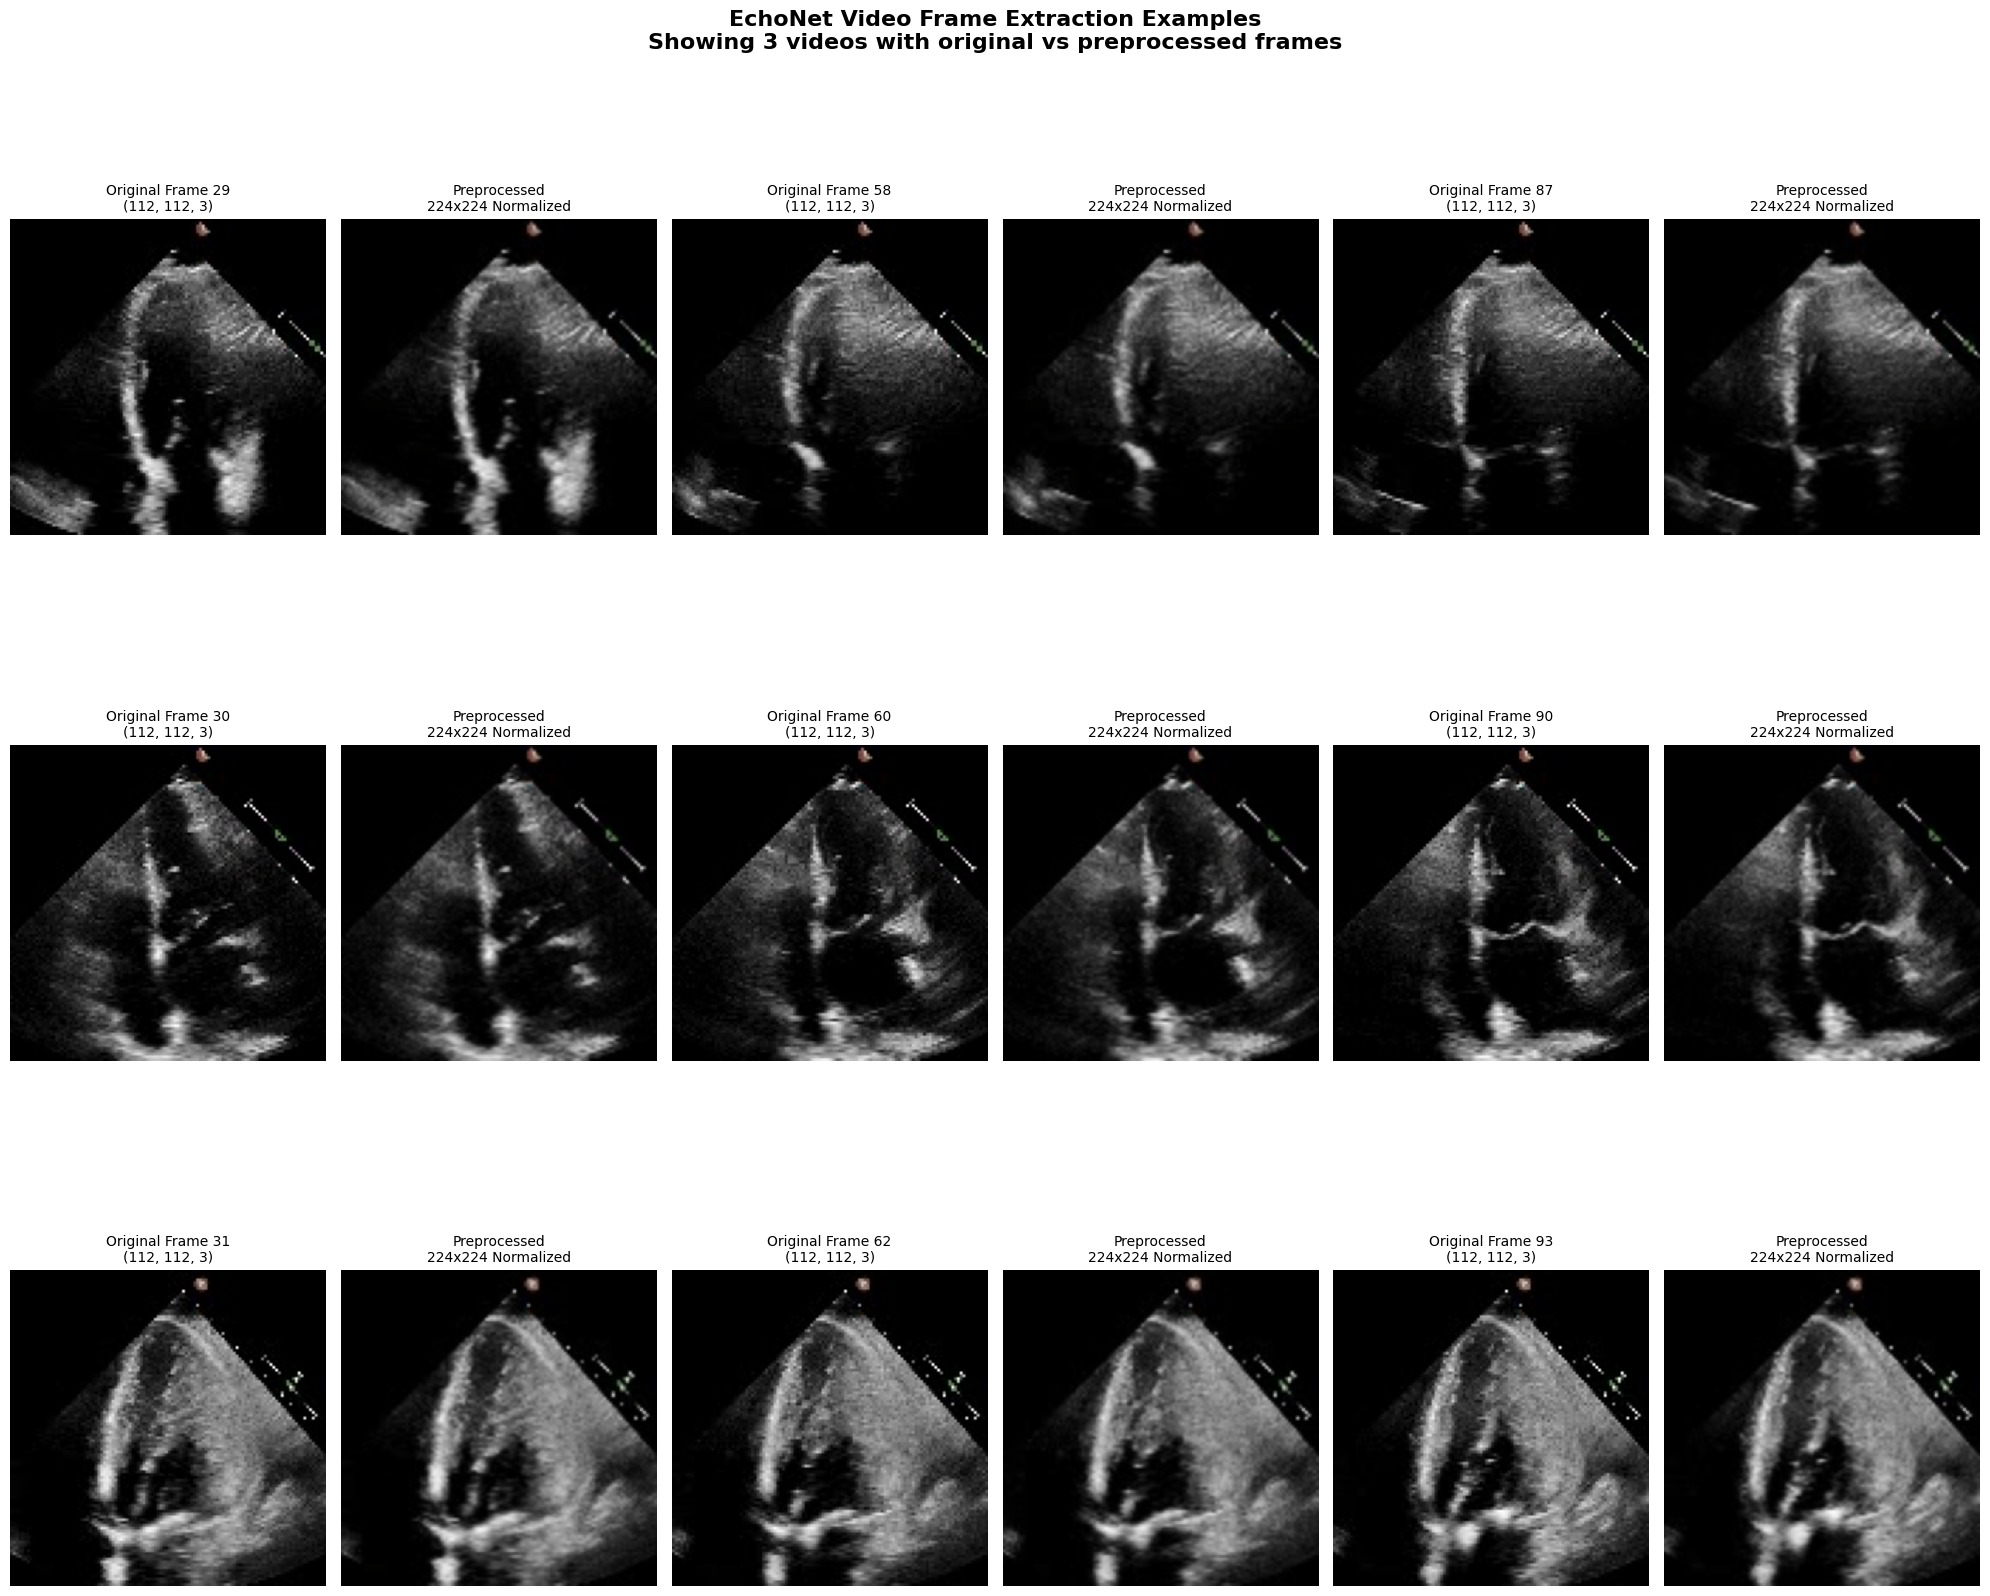

Visualization complete: 3 videos processed


In [227]:
visualized_count = visualize_video_frame_extraction(
        echonet_filelist, videos_path, transform, max_videos=3, frames_per_video=3
    )

## Train feature fusion model

In [228]:
# def train_fusion_model(aligned_numerical, aligned_cnn_features, aligned_labels, 
#                       epochs=100, batch_size=32, learning_rate=0.001):
#     """Train the CNN+MLP feature fusion model"""
#     print("="*50)
#     print("TRAINING FEATURE FUSION MODEL")
#     print("="*50)
    
#     # Create fusion model
#     numerical_dim = aligned_numerical.shape[1]
#     fusion_model = create_fusion_model(numerical_dim)
    
#     # Convert to PyTorch tensors
#     #X_numerical = torch.FloatTensor(aligned_numerical)
#     y = torch.LongTensor(aligned_labels)
    
#     if aligned_cnn_features is not None:
#         X_cnn = torch.FloatTensor(aligned_cnn_features)
#         print("Training with both numerical and CNN features (multimodal)")
#     else:
#         X_cnn = None
#         print("Training with numerical features only")
    
#     # Split data
#     indices = np.arange(len(aligned_numerical))
#     train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=aligned_labels)
    
#     X_train_num = X_numerical[train_idx]
#     X_test_num = X_numerical[test_idx]
#     y_train = y[train_idx]
#     y_test = y[test_idx]
    
#     if X_cnn is not None:
#         X_train_cnn = X_cnn[train_idx]
#         X_test_cnn = X_cnn[test_idx]
#     else:
#         X_train_cnn = X_test_cnn = None
    
#     print(f"Training set: {len(X_train_num)} samples")
#     print(f"Test set: {len(X_test_num)} samples")
#     print(f"Class distribution - Train: {Counter(y_train.numpy())}")
#     print(f"Class distribution - Test: {Counter(y_test.numpy())}")
    
#     # Training setup
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(fusion_model.parameters(), lr=learning_rate, weight_decay=1e-4)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
#     # Training loop
#     fusion_model.train()
#     train_losses = []
#     train_accuracies = []
    
#     print(f"\nTraining for {epochs} epochs...")
    
#     for epoch in range(epochs):
#         total_loss = 0
#         correct = 0
#         total = 0
        
#         # Create batches
#         n_batches = len(X_train_num) // batch_size + (1 if len(X_train_num) % batch_size != 0 else 0)
        
#         for batch_idx in range(n_batches):
#             start_idx = batch_idx * batch_size
#             end_idx = min((batch_idx + 1) * batch_size, len(X_train_num))
            
#             batch_num = X_train_num[start_idx:end_idx]
#             batch_labels = y_train[start_idx:end_idx]
            
#             if X_train_cnn is not None:
#                 batch_cnn = X_train_cnn[start_idx:end_idx]
#             else:
#                 batch_cnn = None
            
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs, mlp_features = fusion_model(batch_num, batch_cnn)
#             loss = criterion(outputs, batch_labels)
            
#             # Backward pass
#             loss.backward()
#             optimizer.step()
            
#             # Statistics
#             total_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += batch_labels.size(0)
#             correct += (predicted == batch_labels).sum().item()
        
#         scheduler.step()
        
#         # Calculate epoch metrics
#         epoch_loss = total_loss / n_batches
#         epoch_acc = 100 * correct / total
        
#         train_losses.append(epoch_loss)
#         train_accuracies.append(epoch_acc)
        
#         if (epoch + 1) % 20 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
#     # Final evaluation
#     fusion_model.eval()
#     with torch.no_grad():
#         test_outputs, _ = fusion_model(X_test_num, X_test_cnn)
#         _, test_predicted = torch.max(test_outputs, 1)
#         test_accuracy = (test_predicted == y_test).float().mean().item()
    
#     print(f"\nFINAL RESULTS:")
#     print(f"Test Accuracy: {test_accuracy:.4f}")
#     print(f"Final Training Loss: {train_losses[-1]:.4f}")
#     print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    
#     # Return comprehensive results
#     results = {
#         'model': fusion_model,
#         'test_accuracy': test_accuracy,
#         'y_test': y_test.numpy(),
#         'y_pred': test_predicted.numpy(),
#         'train_losses': train_losses,
#         'train_accuracies': train_accuracies,
#         'X_test_num': X_test_num.numpy(),
#         'X_test_cnn': X_test_cnn.numpy() if X_test_cnn is not None else None,
#         'alignment_strategy': alignment_strategy if 'alignment_strategy' in globals() else 'unknown'
#     }
    
#     return results

In [229]:
def train_fusion_model(
    aligned_numerical, 
    aligned_cnn_features, 
    aligned_labels, 
    epochs=100, 
    batch_size=32, 
    learning_rate=0.001,
    groups=None,           
    seed=42
):
    """Train the CNN+MLP feature fusion model (fixed, no leakage)."""
    print("="*50)
    print("TRAINING FEATURE FUSION MODEL")
    print("="*50)

    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)

    # ----- Tạo model
    numerical_dim = aligned_numerical.shape[1]
    fusion_model = create_fusion_model(numerical_dim)

    # ----- Chia tập (stratify; hoặc group-split nếu có groups)
    indices = np.arange(len(aligned_numerical))
    y_np = np.asarray(aligned_labels, dtype=int)

    if groups is not None:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
        train_idx, test_idx = next(gss.split(indices, y_np, groups=groups))
    else:
        train_idx, test_idx = train_test_split(
            indices, test_size=0.2, random_state=seed, stratify=y_np
        )

    # ----- Fit scaler trên TRAIN, rồi transform cả train & test (tránh leakage)
    num_scaler = StandardScaler().fit(aligned_numerical[train_idx])
    X_train_num_np = num_scaler.transform(aligned_numerical[train_idx])
    X_test_num_np  = num_scaler.transform(aligned_numerical[test_idx])

    if aligned_cnn_features is not None:
        cnn_scaler = StandardScaler().fit(aligned_cnn_features[train_idx])
        X_train_cnn_np = cnn_scaler.transform(aligned_cnn_features[train_idx])
        X_test_cnn_np  = cnn_scaler.transform(aligned_cnn_features[test_idx])
        print("Training with both numerical and CNN features (multimodal)")
    else:
        X_train_cnn_np = X_test_cnn_np = None
        print("Training with numerical features only")

    # ----- Convert sang torch tensors
    X_train_num = torch.tensor(X_train_num_np, dtype=torch.float32)
    X_test_num  = torch.tensor(X_test_num_np,  dtype=torch.float32)
    y_train = torch.tensor(y_np[train_idx], dtype=torch.long)
    y_test  = torch.tensor(y_np[test_idx],  dtype=torch.long)

    if X_train_cnn_np is not None:
        X_train_cnn = torch.tensor(X_train_cnn_np, dtype=torch.float32)
        X_test_cnn  = torch.tensor(X_test_cnn_np,  dtype=torch.float32)
    else:
        X_train_cnn = X_test_cnn = None

    print(f"Training set: {len(X_train_num)} samples")
    print(f"Test set: {len(X_test_num)} samples")
    print(f"Class distribution - Train: {Counter(y_train.numpy())}")
    print(f"Class distribution - Test:  {Counter(y_test.numpy())}")

    # ----- Loss/opt/scheduler
    class_counts = np.bincount(y_train.numpy(), minlength=2)
    class_weights = (class_counts.sum() / (class_counts + 1e-6)).astype(np.float32)
    class_weights = class_weights / class_weights.mean()  # normalize
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

    optimizer = optim.Adam(fusion_model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    # ----- Train loop
    fusion_model.train()
    train_losses = []
    train_accuracies = []
    print(f"\nTraining for {epochs} epochs...")

    n_train = X_train_num.size(0)
    for epoch in range(epochs):
        # shuffle mỗi epoch
        perm = torch.randperm(n_train)
        X_train_num = X_train_num[perm]
        y_train = y_train[perm]
        if X_train_cnn is not None:
            X_train_cnn = X_train_cnn[perm]

        total_loss = 0.0
        correct = 0
        total = 0

        n_batches = (n_train + batch_size - 1) // batch_size
        for b in range(n_batches):
            s = b * batch_size
            e = min((b + 1) * batch_size, n_train)

            batch_num = X_train_num[s:e]
            batch_lbl = y_train[s:e]
            batch_cnn = X_train_cnn[s:e] if X_train_cnn is not None else None

            optimizer.zero_grad()
            outputs, _ = fusion_model(batch_num, batch_cnn)  # (N, 2)
            loss = criterion(outputs, batch_lbl)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += batch_lbl.size(0)
            correct += (pred == batch_lbl).sum().item()

        scheduler.step()
        epoch_loss = total_loss / n_batches
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.2f}%")

    # ----- Evaluate
    fusion_model.eval()
    with torch.no_grad():
        test_outputs, _ = fusion_model(X_test_num, X_test_cnn)
        _, test_predicted = test_outputs.max(1)
        test_accuracy = (test_predicted == y_test).float().mean().item()

    print("\nFINAL RESULTS:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")

    results = {
        "model": fusion_model,
        "test_accuracy": test_accuracy,
        "y_test": y_test.cpu().numpy(),
        "y_pred": test_predicted.cpu().numpy(),
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "X_test_num": X_test_num.cpu().numpy(),
        "X_test_cnn": X_test_cnn.cpu().numpy() if X_test_cnn is not None else None,
        "alignment_strategy": alignment_strategy if "alignment_strategy" in globals() else "unknown"
    }
    return results

In [230]:
if 'aligned_numerical' in locals() and aligned_numerical is not None:
    fusion_results = train_fusion_model(
        aligned_numerical, aligned_cnn_features, aligned_labels,
        epochs=80, batch_size=16, learning_rate=0.001, groups=group_ids, seed=42
    )
    
    print(f"\nFusion Model Training Completed!")
    print(f"Final Test Accuracy: {fusion_results['test_accuracy']:.4f}")

TRAINING FEATURE FUSION MODEL
Training with both numerical and CNN features (multimodal)
Training set: 216 samples
Test set: 55 samples
Class distribution - Train: Counter({np.int64(0): 132, np.int64(1): 84})
Class distribution - Test:  Counter({np.int64(0): 32, np.int64(1): 23})

Training for 80 epochs...
Epoch [20/80]  Loss: 0.0039  Acc: 100.00%
Epoch [40/80]  Loss: 0.0005  Acc: 100.00%
Epoch [60/80]  Loss: 0.0025  Acc: 100.00%
Epoch [80/80]  Loss: 0.0003  Acc: 100.00%

FINAL RESULTS:
Test Accuracy: 0.8727
Final Training Loss: 0.0003
Final Training Accuracy: 100.00%

Fusion Model Training Completed!
Final Test Accuracy: 0.8727


In [231]:
def visualize_fusion_results(fusion_results):
    """Comprehensive visualization for fusion model results"""
    print("Creating comprehensive visualizations...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Training Loss Curve
    axes[0,0].plot(fusion_results['train_losses'], 'b-', linewidth=2, marker='o', markersize=2)
    axes[0,0].set_title('Training Loss Curve', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Training Accuracy Curve
    axes[0,1].plot(fusion_results['train_accuracies'], 'g-', linewidth=2, marker='s', markersize=2)
    axes[0,1].set_title('Training Accuracy Curve', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy (%)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Confusion Matrix
    cm = confusion_matrix(fusion_results['y_test'], fusion_results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2], 
                cbar_kws={'label': 'Count'})
    axes[0,2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0,2].set_xlabel('Predicted')
    axes[0,2].set_ylabel('Actual')
    
      
    # 5. Performance Metrics
    accuracy = fusion_results['test_accuracy']
    
    # Calculate additional metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(
        fusion_results['y_test'], fusion_results['y_pred'], average='weighted'
    )
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    bars = axes[1,0].bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    axes[1,0].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Class Distribution and Strategy Info
    class_dist = Counter(fusion_results['y_test'])
    classes = ['No Disease (0)', 'Disease (1)']
    counts = [class_dist.get(0, 0), class_dist.get(1, 0)]
    colors_pie = ['#98D8C8', '#F7DC6F']
    
    wedges, texts, autotexts = axes[1,1].pie(counts, labels=classes, colors=colors_pie, 
                                           autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    
    # Add strategy info
    strategy_info = fusion_results.get('alignment_strategy', 'Unknown')
    axes[1,1].text(0, -1.3, f'Alignment Strategy: {strategy_info}', 
                   ha='center', va='center', fontsize=10, style='italic',
                   transform=axes[1,1].transData)
    
    plt.tight_layout()
    plt.show()


    axes[1,2].axis('off')  
    
    
    # Print detailed results
    print("\n" + "="*70)
    print("COMPREHENSIVE FUSION MODEL RESULTS")
    print("="*70)
    print(f"Final Test Accuracy: {fusion_results['test_accuracy']:.4f}")
    print(f"Final Training Loss: {fusion_results['train_losses'][-1]:.4f}")
    print(f"Final Training Accuracy: {fusion_results['train_accuracies'][-1]:.2f}%")
    print(f"Alignment Strategy: {fusion_results.get('alignment_strategy', 'Unknown')}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(fusion_results['y_test'], fusion_results['y_pred'], 
                              target_names=['No Disease', 'Heart Disease']))

Creating comprehensive visualizations...


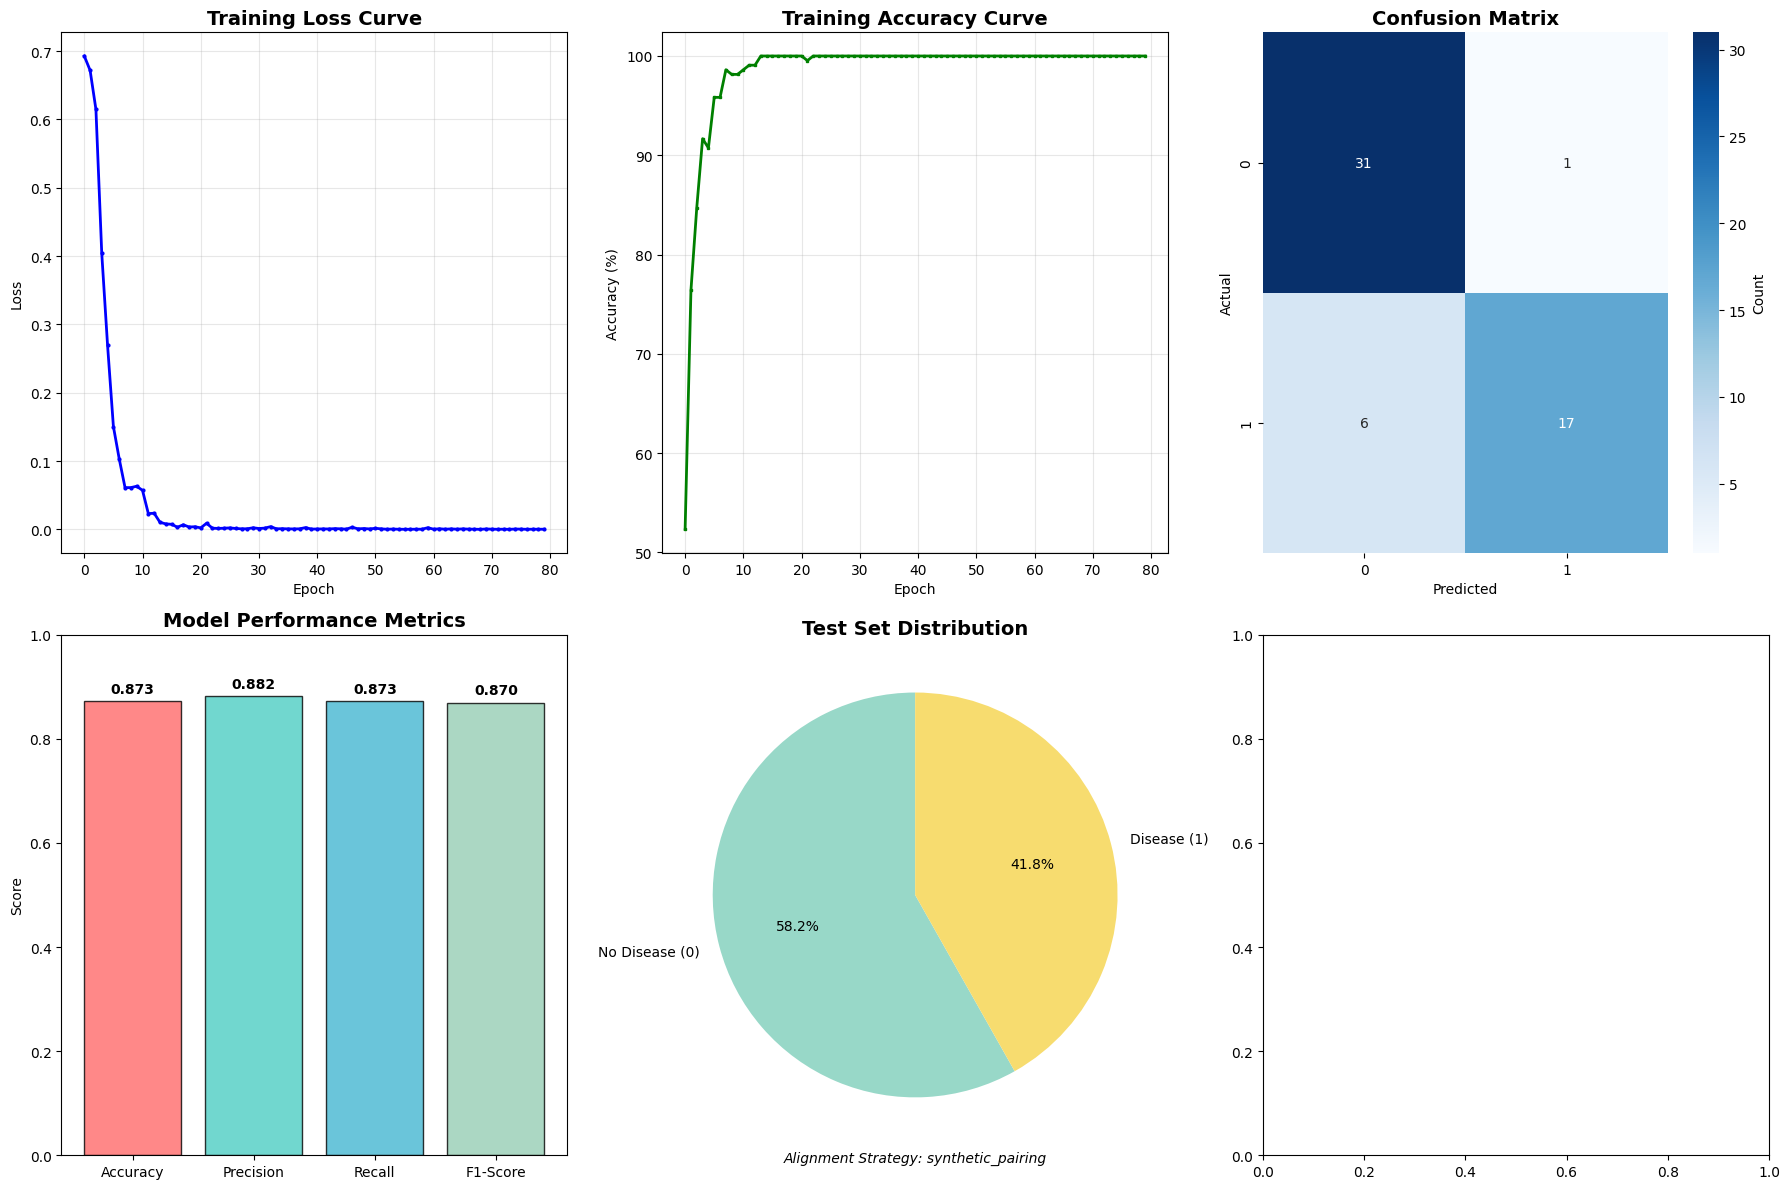


COMPREHENSIVE FUSION MODEL RESULTS
Final Test Accuracy: 0.8727
Final Training Loss: 0.0003
Final Training Accuracy: 100.00%
Alignment Strategy: synthetic_pairing

Detailed Classification Report:
               precision    recall  f1-score   support

   No Disease       0.84      0.97      0.90        32
Heart Disease       0.94      0.74      0.83        23

     accuracy                           0.87        55
    macro avg       0.89      0.85      0.86        55
 weighted avg       0.88      0.87      0.87        55



In [232]:
if 'fusion_results' in locals():
    visualize_fusion_results(fusion_results)